# Asymmetry `n_m_bg_start=2`

In [1]:
cd ..

/home/astro/phrdhx/automated_exocomet_hunt


In [2]:
import lightkurve as lk
from matplotlib import pyplot as  plt
import numpy as np
from astropy.table import Table
from analysis_tools_cython import *
import scipy.integrate as integrate
import numpy as np
from scipy.signal import savgol_filter

plt.rcParams["figure.figsize"] = (10, 6)

## Functions

In [3]:
def skewed_gaussian_curve_fit2(x,y,y_err):
    # exploratory curve fitting function. not to be confused with skewed_gaussian_curve_fit from analysis_tools_cython
    # Initial parameters guess
    ## i = index of min time
    ## x = time
    ## y = flux
    
    i = np.argmin(y)
    width = x[-1]-x[0]
    ### params initialisation for skewness, time, mean and sigma
    params_init = [0.1,x[i],0.1,0.0001] # i find these good to initialise with
    
    params_bounds = [[-np.inf,x[0],0,0], [np.inf,x[-1],np.inf,np.inf]]
    
#     A0 = y[i]
#     mu0 = x[i]
#     sigma0 = (x[-1]-x[0])/4

#     params_bounds = [[0.1,x[0],0,0], [10,x[-1],np.inf,sigma0*4]]

    params,cov = curve_fit(skewed_gaussian,x,y,p0=params_init,bounds=params_bounds,sigma=y_err,maxfev=1000000)
    return params, cov 

def skewed_gaussian(x,a,mean,sigma,m):
    """
    m: amplitude
    x: time
    a: skewness
    mean: time
    sigma: sigma/standard deviation    
    
    """
    return -m * skewnorm.pdf(x,a,loc=mean,scale=sigma)

def lookup_tic(tic):
    return lookup[lookup.TIC_ID == tic]

def search_method(data):
    try:
        data = data['time','corrected flux','quality','flux error']
    except:
        data = data['TIME','PDCSAP_FLUX','QUALITY','PDCSAP_FLUX_ERR']
        
    try:
        data['corrected flux'] = normalise_error(data['corrected flux'],data['flux error'])
    except:
        data['PDCSAP_FLUX_ERR'] = normalise_error(data['PDCSAP_FLUX'],data['PDCSAP_FLUX_ERR'])

    flat_flux, trend_flux = smoothing(data,method='median')
    a = Table()
    a['time'] = data[data.colnames[0]]
    a['flux'] = flat_flux - np.ones(len(flat_flux))
    a['quality'] = data[data.colnames[2]]
    a['flux_error'] = data[data.colnames[3]]
    #table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
    t, flux, quality, real, flux_error = clean_data(a)
    flux *= real
    timestep = calculate_timestep(data)
    factor = ((1/48)/timestep)

    T1 = test_statistic_array(flux,60 * factor)

    m, n = np.unravel_index(
    T1.argmin(), T1.shape
    )  # T.argmin(): location of  T.shape: 2D array with x,y points in that dimension
    minT = T1[m, n]
    #Ts = nonzero(T1[m,n]).std()
    minT_time = t[n]
    minT_duration = m * timestep
    Tm_start = n-math.floor((m-1)/2)
    Tm_end = Tm_start + m
    Tm_depth = flux[Tm_start:Tm_end].mean() 
    Ts = nonzero(T1[m]).std() # only the box width selected. Not RMS of all T-statistic
    
    asym, width1, width2, depth, info, skewness, skewness_error = calc_shape2(m,n,t,flux,quality,flux_error)
    return info[0], info[1], info[3]

def plot(data):
    time, flux, error = search_method(data)
    fig, ax = plt.subplots(1,2,figsize=(15,7))
    try:
        ax[0].plot(data["time"],data["corrected flux"])
    except:
        ax[0].plot(data["TIME"],data["PDCSAP_FLUX"])
    ax[1].plot(time,flux)
    ax[1].plot(time,fit,label='gaussian')
    ax[1].plot(time,fit2,color='black',label='skewed gaussian')
    ax[1].legend()
    #ax[1].errorbar(time,flux, yerr=error, fmt='', color='b')
    plt.show()
    
def calc_reduced_chi_square(fit, x, y, yerr, N, n_free):
    '''
    fit (array) values for the fit
    x,y,yerr (arrays) data
    N total number of points
    n_free number of parameters we are fitting
    '''
    return 1.0/(N-n_free)*sum(((fit - y)/yerr)**2)

def normalise_error(flux, flux_error):
    return flux_error/np.nanmedian(flux)

def calc_shape2(m,n,time,flux,quality,flux_error,n_m_bg_start=3,n_m_bg_scale_factor=1):
    # exploratory cutout function. not to be confused with calc_shape from analysis_tools_cython
    """Fit both symmetric and comet-like transit profiles and compare fit.
    Returns:
    (1) Asymmetry: ratio of (errors squared)
    Possible errors and return values:
    -1 : Divide by zero as comet profile is exact fit
    -2 : Too close to end of light curve to fit profile
    -3 : Unable to fit model (e.g. timeout)
    -4 : Too much empty space in overall light curve or near dip
    (2,3) Widths of comet curve fit segments.
    info: t, x, q, fit1 and fit2 are the transit shape elements 

    """
    ## how many transit widths to take the general linear trend from. start is 1/4 length of cutout from beginning, end is 1 from end.
    #first_index = n - (n_m_bg_start*n)
    #last_index = n - (n_m_bg_end*m)
    
    
    ## the transit widths of the cutout from the T-statistic minimum value. 
    ## this project requires the cutout to have more transit widths after the midtransit, to cover more of the tail.
    ## default is set to 1 transit width before and 2 transit widths after 

    n_m_bg_end = n_m_bg_scale_factor*n_m_bg_start

    cutout_before = n-(m*n_m_bg_start)
    cutout_after = n+(m*n_m_bg_end)
    
    if cutout_before>= 0 and cutout_after < len(time):
        t = time[cutout_before:cutout_after]
        if (t[-1]-t[0]) / np.median(np.diff(t)) / len(t) > 1.5:
            return -4,-4,-4,-4,-4,-4,-4
        t0 = time[n]
        diffs = np.diff(t)

        x = flux[cutout_before:cutout_after]
        q = quality[cutout_before:cutout_after]
        fe = flux_error[cutout_before:cutout_after]
        
        bg_before = np.mean(x[:int(m/4)])
        bg_time_before = np.mean(t[:int(m/4)])
        bg_after = np.mean(x[-int(round(m/4)):])
        bg_time_after = np.mean(t[-int(round(m/4)):])
        
        
        grad = (bg_after-bg_before)/(bg_time_after-bg_time_before)
        background_level = bg_before + grad * (t - bg_time_before)
        x = x - background_level

        try:
            params1, pcov1 = single_gaussian_curve_fit(t,-x)
            params2, pcov2 = comet_curve_fit(t,-x)
            params3, pcov3 = skewed_gaussian_curve_fit2(t,x,fe)
        except:
            return -3,-3,-3,-3,-3,-3,-3

        fit1 = -gauss(t,*params1)
        fit2 = -comet_curve(t,*params2)
        fit3 = skewed_gaussian(t,*params3)
        depth = fit2.min() # depth of comet (based on minimum point; not entirely accurate, but majority of the time true)
        min_time = t[np.argmin(x)] # time of midtransit/at minimum point
        scores = [score_fit(x,fit) for fit in [fit1,fit3]] # changed for the skewed gaussian fit
        if scores[1] > 0:
            skewness = params3[0]
            skewness_error = np.sqrt(np.diag(pcov3)[0])
            return scores[0]/scores[1], params2[2], params2[3], depth, [t,x,q,fe,fit1,fit2,fit3,background_level], skewness, skewness_error
        else:

            return -1,-1,-1,-1,-1,-1,-1
    else:     

        return -2,-2,-2,-2,-2,-2,-2

In [4]:
lookup = pd.read_csv("/storage/astro2/phrdhx/tesslcs/sector1lookup.csv")

## Example 1

In [5]:
data, lc_info = import_lightcurve("betapic/test/hlsp_tess-spoc_tess_phot_0000000270577175-s0006_tess_v1_lc.fits")

In [6]:
data

TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
float64,float32,int32,float32
1468.3041536038627,5507612.0,0,64.86285
1468.3249869523263,5507246.5,0,64.86083
1468.34582030044,5507478.5,0,64.86304
1468.3666536480885,5508482.0,0,64.867645
1468.4083203422217,5507866.5,0,64.86058
1468.4291536885903,5507848.0,0,64.85632
1468.4499870347247,5507829.0,0,64.863525
1468.4708203803937,5507612.0,0,64.859375
1468.4916537255983,5508535.0,0,64.865974


In [7]:
# data = data['TIME','PDCSAP_FLUX','QUALITY','PDCSAP_FLUX_ERR']
# data['PDCSAP_FLUX_ERR'] = normalise_error(data['PDCSAP_FLUX'],data['PDCSAP_FLUX_ERR'])

# flat_flux, trend_flux = smoothing(data,method='median')
# a = Table()
# a['time'] = data[data.colnames[0]]
# a['flux'] = flat_flux - np.ones(len(flat_flux))
# a['quality'] = data[data.colnames[2]]
# a['flux_error'] = data[data.colnames[3]]
# #table[table.colnames[1]] = flat_flux - np.ones(len(flat_flux)) # resets normalisation to zero instead of one.
# t, flux, quality, real, flux_error = clean_data(a)
# flux *= real

In [8]:
# len(flux)

In [9]:
# len(flux_error)

In [10]:
time, flux, error = search_method(data)

In [11]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux,error)

In [12]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 1.439+/-0.46557910873894437


In [13]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

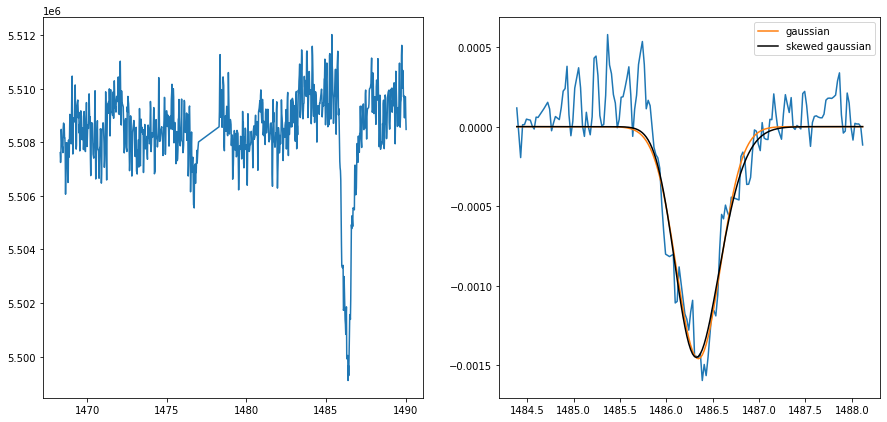

In [14]:
plot(data)

In [15]:
len(flux)

180

### 1a. Flip this lightcurve to see if the skew works in reverse as well

In [16]:
data = data.to_pandas()

In [17]:
data.head()

,TIME,PDCSAP_FLUX,QUALITY,PDCSAP_FLUX_ERR
0,1468.304154,5507612.0,0,64.862846
1,1468.324987,5507246.5,0,64.860832
2,1468.345820,5507478.5,0,64.863037
3,1468.366654,5508482.0,0,64.867645
4,1468.408320,5507866.5,0,64.860580


In [18]:
data.PDCSAP_FLUX = data.PDCSAP_FLUX.values[::-1]

In [19]:
data = Table.from_pandas(data)

In [20]:
time, flux, error = search_method(data)

In [21]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux,error)

In [22]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -1.822+/-0.4576685449835411


In [23]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

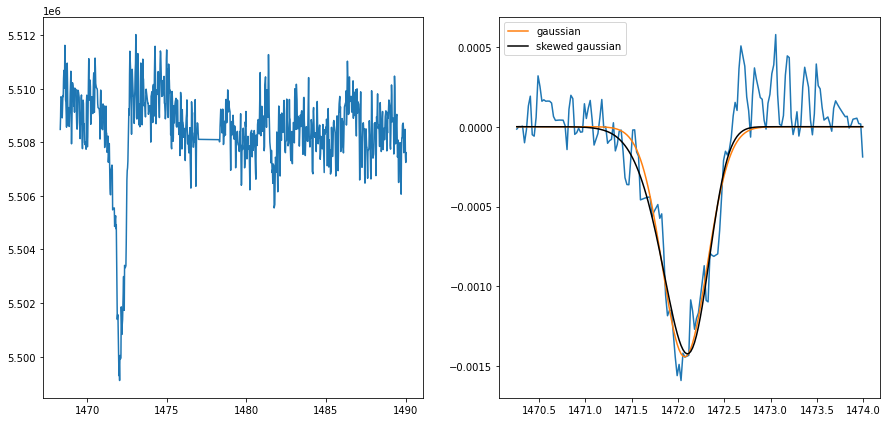

In [24]:
plot(data)

Appears to fit the data quite well.

### Goodness of fit of model

In [25]:
calc_reduced_chi_square(fit2,time,flux,error,len(flux),4)

219.39694175969322

In [26]:
#chisquare(flux,fit2)

---

## Example 2 (CTOI)

In [27]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_50380257.pkl",sector=1)

In [28]:
time, flux, error = search_method(data)

In [29]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [30]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 1.505+/-0.7132362289980057


In [31]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

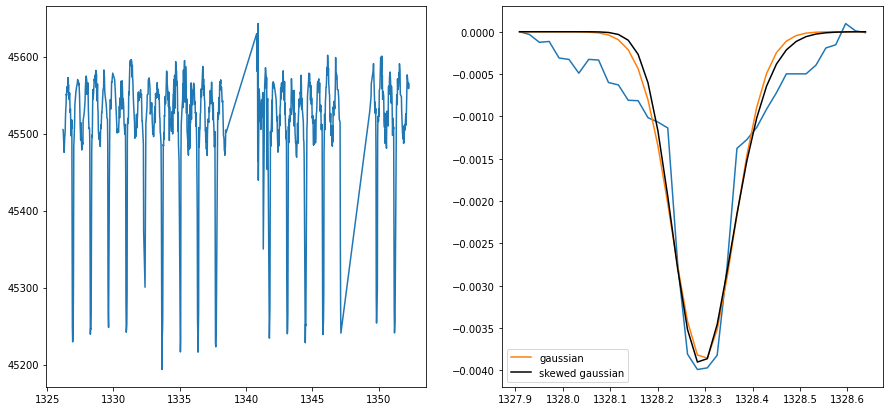

In [32]:
plot(data)

In [33]:
len(flux)

36

---
## Example 3 (CTOI)

In [34]:
lookup_tic(55659311)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12943,tesslcs_sector_1_104/2_min_cadence_targets/tes...,74.117326,-64.48753,55659311,1,4,1,9.7909


In [35]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_55659311.pkl",sector=1)

In [36]:
time, flux, error = search_method(data)

In [37]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [38]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 0.002+/-17897.010988843605


In [39]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

In [40]:
fit

array([-5.67514770e-18, -2.96503416e-17, -1.49215342e-16, -7.23331809e-16,
       -3.37740872e-15, -1.51901102e-14, -6.58074252e-14, -2.74608867e-13,
       -1.10379651e-12, -4.27357246e-12, -1.59377792e-11, -5.72524318e-11,
       -1.98102331e-10, -6.60267104e-10, -2.11972363e-09, -6.55495878e-09,
       -1.95249711e-08, -5.60198682e-08, -1.54820677e-07, -4.12139492e-07,
       -1.05679186e-06, -2.61016626e-06, -6.20978901e-06, -1.42303530e-05,
       -3.14112882e-05, -6.67862518e-05, -1.36780100e-04, -2.69828173e-04,
       -5.12723022e-04, -9.38446450e-04, -1.65450212e-03, -2.80967651e-03,
       -4.59596249e-03, -7.24148766e-03, -1.09903186e-02, -1.60665985e-02,
       -2.26239676e-02, -3.06863175e-02, -4.00914455e-02, -5.04533849e-02,
       -6.11589245e-02, -7.14102488e-02, -8.03142168e-02, -8.70072584e-02,
       -9.07924422e-02, -9.12588815e-02, -8.83551533e-02, -8.23986189e-02,
       -7.40183301e-02, -6.40456934e-02, -5.33791777e-02, -4.28533838e-02,
       -3.31382425e-02, -

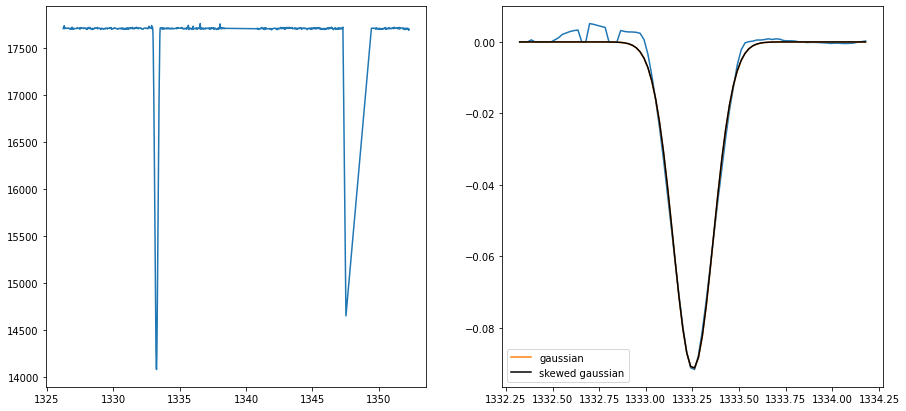

In [41]:
plot(data)

In [42]:
len(flux)

90

---
## Example 4 (EA2)

In [43]:
lookup_tic(60646247)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
53662,tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc...,334.360488,-33.134487,60646247,1,1,2,11.851


In [44]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_11_12/tesslc_60646247.pkl",sector=1)

In [45]:
time, flux, error = search_method(data)

In [46]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [47]:
np.diag(cov1)

array([3.64433836e-01, 5.01308578e-04, 5.06148796e-05, 2.64691940e-08])

In [48]:
np.sqrt((cov1)[0,0])

0.6036835562345504

In [49]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 0.405+/-0.6036835562345504


In [50]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

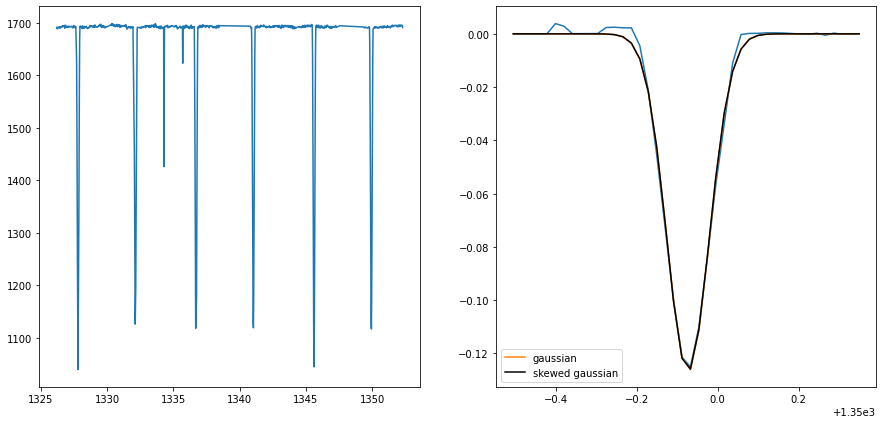

In [51]:
plot(data)

In [52]:
len(flux)

42

---
## Example 5 (WASP 100)

In [53]:
lookup_tic(38846515)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
12850,tesslcs_sector_1_104/2_min_cadence_targets/tes...,68.959709,-64.027037,38846515,1,4,1,10.3157


In [54]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_38846515.pkl",sector=1)

In [55]:
time, flux, error = search_method(data)

In [56]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [57]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -101.379+/-195.3681841849953


In [58]:
params

array([3.56288217e-03, 1.32876974e+03, 8.48534612e-01])

In [59]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

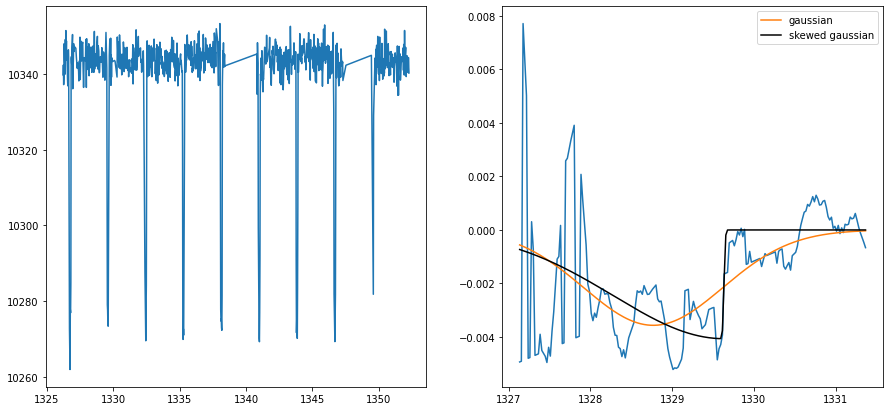

In [60]:
plot(data)

In [61]:
len(flux)

204

---
## Example 6

In [62]:
lookup_tic(61178236)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
43296,tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc...,334.803809,-31.688934,61178236,1,1,2,10.8952


In [63]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/tesslcs_tmag_10_11/tesslc_61178236.pkl",sector=1)

In [64]:
time, flux, error = search_method(data)

In [65]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [66]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is -0.698+/-0.4269758081691371


In [67]:
params

array([6.00205344e-02, 1.35117618e+03, 3.33182092e-02])

In [68]:
params1

array([-6.97506356e-01,  1.35119301e+03,  3.77928746e-02,  5.03394254e-03])

In [69]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

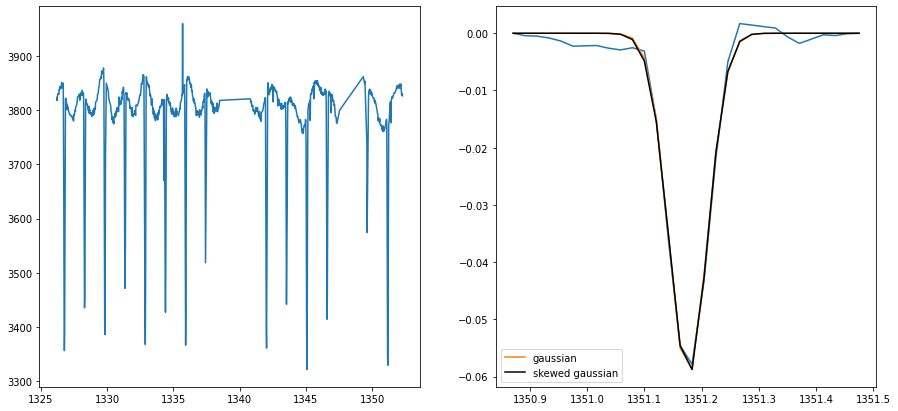

In [70]:
plot(data)

In [71]:
len(flux)

30

### Test interpolate

In [72]:
arange = np.linspace(time.min(),time.max(),5000)
interp = np.interp(arange,time,flux)

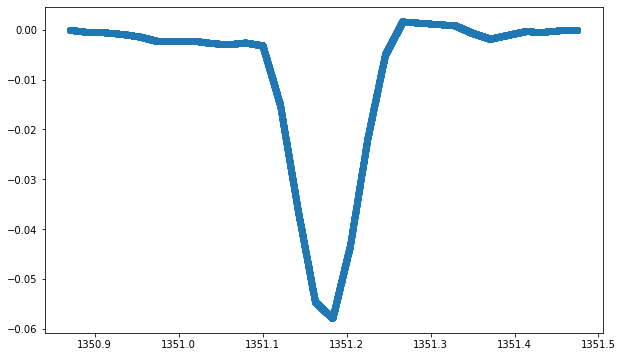

In [73]:
plt.scatter(arange,interp)

## Example 7

In [74]:
lookup_tic(441422220)

,Filename,RA,Dec,TIC_ID,Sector,Camera,CCD,Magnitude
6223,tesslcs_sector_1_104/2_min_cadence_targets/tes...,311.362145,-34.646424,441422220,1,1,4,9.0641


In [75]:
data, lc_info = import_XRPlightcurve("/storage/astro2/phrdhx/tesslcs/tesslcs_sector_1_104/2_min_cadence_targets/tesslc_441422220.pkl",sector=1)

In [76]:
time, flux, error = search_method(data)

In [77]:
params, cov = single_gaussian_curve_fit(time,-flux)
params1, cov1 = skewed_gaussian_curve_fit2(time,flux, error)

In [78]:
print(f"skewness is {round(params1[0],3)}+/-{np.sqrt(np.diag(cov1)[0])}")

skewness is 0.385+/-1.4001884414642773


In [79]:
params

array([1.50369558e-01, 1.35089298e+03, 4.06669776e-02])

In [80]:
params1

array([3.85035519e-01, 1.35088081e+03, 4.28401740e-02, 1.53957604e-02])

In [81]:
fit = -gauss(time,*params)
fit2 = skewed_gaussian(time,*params1)

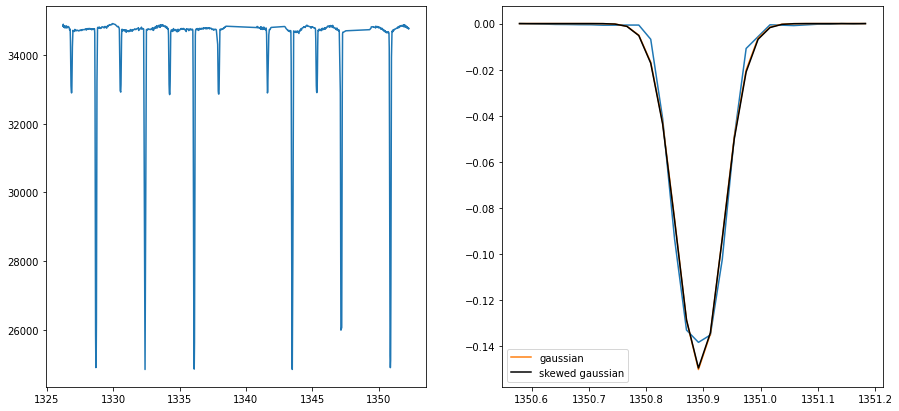

In [82]:
plot(data)

In [83]:
len(flux)

30